In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk import tokenize
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.utils import shuffle
from textblob import TextBlob
import subprocess

# Reading and preparing data

In [2]:
isear=pd.read_csv("ISEAR.csv",header=None)
isear=isear.drop(labels=[2],axis=1).set_index(0)
isear

,1
0,
joy,On days when I feel close to my partner and ot...
fear,Every time I imagine that someone I love or I ...
anger,When I had been obviously unjustly treated and...
sadness,When I think about the short time that we live...
disgust,At a gathering I found myself involuntarily si...
...,...
shame,Two years back someone invited me to be the tu...
shame,I had taken the responsibility to do something...
fear,I was at home and I heard a loud sound of spit...


In [3]:
np.unique(isear.index,return_counts=True)

(array(['anger', 'disgust', 'fear', 'guilt', 'guit', 'joy', 'sadness',
        'shame'], dtype=object),
 array([1079, 1066, 1076, 1049,    1, 1092, 1082, 1071]))

In [4]:
df=isear.loc[['anger','disgust','fear','sadness','joy']]
df

,1
0,
anger,When I had been obviously unjustly treated and...
anger,When a car is overtaking another and I am forc...
anger,When one is unjustly accused of something one ...
anger,When my partner was attacked and lost three te...
anger,Unjust accusations directed at me and my way o...
...,...
joy,When I received a letter from the university t...
joy,"I had a picnic with old classmates, we chatted..."
joy,It was the first time that I gave a birthday p...


# Expanding dataset with lexicon

In [5]:
lexi=pd.read_csv("NRC_emotion_lexicon_list.txt",delimiter="\t",header=None)
lexi=lexi.dropna()

In [7]:
lexiFilt=lexi
lexiFilt=lexiFilt.set_index(2)
lexiFilt=lexiFilt.loc[1]
lexiFilt=lexiFilt.set_index(1)
lexiFilt[1]=lexiFilt[0]
lexiFilt=lexiFilt.drop(0,axis=1)

In [8]:
Emotions=['anger', 'disgust', 'fear', 'joy', 'sadness']
for i in Emotions:
    df=df.append(lexiFilt.loc[i])

In [9]:
df=df.sort_index()
df

,1
anger,When I had been obviously unjustly treated and...
anger,dupe
anger,duplicity
anger,duress
anger,dying
...,...
sadness,"I couldn't sleep, and began to remind of my ch..."
sadness,I felt sad when I was despised by another person.
sadness,Some colleagues decided to go out on a Saturda...
sadness,During an informal talk with a friend when we ...


In [10]:
np.unique(df.index, return_counts=1)

(array(['anger', 'disgust', 'fear', 'joy', 'sadness'], dtype=object),
 array([2326, 2124, 2552, 1781, 2273]))

In [11]:
stopwords=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
punkts='''"#$%&\'()*+,-./:;<=>@[\\]^_`{|}~'''

# Data preparation

In [12]:
def CorFilt(i):
    ps = PorterStemmer()
    
    buff=word_tokenize(i.lower().replace("\n","").replace("  "," ").replace("n't"," not"))
    buff2=""
    for j in pos_tag(buff):
        if j[-1]=='RB' and j[0]!="not":
            pass
        else:
            buff2+=j[0]+" "
    buff2=buff2.replace("not ","NOT")
    buff=word_tokenize(buff2.strip())
    ans=""
    for j in buff:
        if (j not in punkts) and (j not in stopwords):
            if j=="!":
                ans+=" XXEXCLMARK"
            elif j=="?":
                ans+=" XXQUESMARK"
            else:
                if j!="'s" and j!="``":
                    ans+=" "+ps.stem(j)
    return ans.strip()

In [13]:
def TFIDF(df):
    Corpus=[]
    for i in df[1]:
        Corpus.append(CorFilt(i))

    vectorizer = TfidfVectorizer()
    vectorizer.fit(Corpus)
    X=vectorizer.transform(Corpus).toarray()
    
    return X,vectorizer

In [14]:
def EmoVekt(df):
    X,vectorizer=TFIDF(df)
    counterS=0
    counterE=0
    emocount=0
    EmoVec=np.zeros((5,X.shape[-1]))
    for i in np.unique(df.index):
        counterE+=df.loc[i].shape[0]
        EmoVec[emocount]=np.mean(X[counterS:counterE,:], axis=0)
        emocount+=1
        counterS=counterE
    return EmoVec,vectorizer

In [15]:
EmoVec,vectorizer=EmoVekt(df)

In [18]:
import pickle
    
f=open("EmoVec","wb")
pickle.dump(EmoVec,f)
f.close()

f=open("vectorizer","wb")
pickle.dump(vectorizer,f)
f.close()

In [21]:
def EmowavE(sent,vectorizer=vectorizer,EmoVec=EmoVec,trans=True):
    
    transDict={'gu':'Gujarati',
               'hi':'Hindi'}
    # Translate from any language to english
    if trans:
        analysis = TextBlob(sent)
        if analysis.detect_language()!='en':
            try:
                print(f"\nInput text was in {transDict[analysis.detect_language()]}")
            except:
                print(f"\nInput text was not in English")
            print("\nTranslating...")
            output=subprocess.check_output(['trans','-b',sent])
            sent=output.decode('utf-8').strip()
            print(f"\nTranslation in English: {sent}")
        
    EmoBuff=vectorizer.transform([CorFilt(sent)])
    EmoDict={0:'anger',
             1:'disgust',
             2:'fear',
             3:'joy',
             4:'sadness'}
    return EmoDict[np.argmax([float(cosine_similarity(EmoBuff.reshape(-1,1).T,EmoVec[i].reshape(-1,1).T)) for i in range(EmoVec.shape[0])])]

In [22]:
def Report(df,EmoVec,vectorizer,report=True,trans=False, ret=True):
    y_pred=[]
    for i in range(len(df)):
        y_pred.append(EmowavE(df[1][i],vectorizer,EmoVec,trans))
    
    if report:
        print(classification_report(df.index,y_pred))
    if ret:
        return y_pred

- This accuracy on the trained data so you may ignore this accuracy, just for our reference

In [23]:
Report(df,EmoVec,vectorizer,ret=False)

              precision    recall  f1-score   support

       anger       0.54      0.65      0.59      2326
     disgust       0.55      0.72      0.62      2124
        fear       0.69      0.56      0.62      2552
         joy       0.75      0.82      0.79      1781
     sadness       0.73      0.46      0.56      2273

    accuracy                           0.63     11056
   macro avg       0.65      0.64      0.64     11056
weighted avg       0.65      0.63      0.63     11056



In [24]:
np.unique(df.index,return_counts=True)

(array(['anger', 'disgust', 'fear', 'joy', 'sadness'], dtype=object),
 array([2326, 2124, 2552, 1781, 2273]))

- We did fivefold crossvalidation. but didn,t mention in report as it was not necessary

In [25]:
def fiveFold(df):
    accList=[]
    
    df = shuffle(df)
    
    interval=int(len(df)/5)
    starter=0
    ender=interval
    
    for i in range(5):
        print(f"~~~~~~~~~~~~~ Fold-{i+1} starting ~~~~~~~~~~~~~")
        traindf=df.iloc[:starter]
        testdf=df.iloc[starter:ender]
        traindf=traindf.append(df.iloc[ender:])
        traindf=traindf.sort_index()
        testdf=testdf.sort_index()

        #Creating corpus
        Corpus=[]
        for i in traindf[1]:
            Corpus.append(CorFilt(i))
        
        #Creating TF-IDF
        vectorizer = TfidfVectorizer()
        vectorizer.fit(Corpus)
        X=vectorizer.transform(Corpus).toarray()
        
        #Creating EmotionVectors
        counterS=0
        counterE=0
        emocount=0
        EmoVec=np.zeros((5,X.shape[-1]))
        for i in np.unique(traindf.index):
            counterE+=traindf.loc[i].shape[0]
            EmoVec[emocount]=np.mean(X[counterS:counterE,:], axis=0)
#             print(i,X[counterS:counterE,:].shape)
            emocount+=1
            counterS=counterE
        
        y_pred=[]
        for i in range(len(testdf)):
            y_pred.append(EmowavE(testdf[1][i],vectorizer,EmoVec))
        
        print(classification_report(y_pred,testdf.index))
        accList.append(accuracy_score(y_pred,testdf.index))
        
        starter+=interval
        ender+=interval
        
    print(f"Five Fold Accuracy is {np.mean(accList)}")

In [21]:
fiveFold(df)

~~~~~~~~~~~~~ Fold-1 starting ~~~~~~~~~~~~~
              precision    recall  f1-score   support

       anger       0.44      0.28      0.34       756
     disgust       0.39      0.34      0.36       452
        fear       0.33      0.41      0.37       407
         joy       0.60      0.67      0.63       325
     sadness       0.29      0.49      0.36       271

    accuracy                           0.40      2211
   macro avg       0.41      0.44      0.41      2211
weighted avg       0.41      0.40      0.40      2211

~~~~~~~~~~~~~ Fold-2 starting ~~~~~~~~~~~~~
              precision    recall  f1-score   support

       anger       0.47      0.28      0.35       790
     disgust       0.35      0.34      0.34       446
        fear       0.32      0.43      0.36       390
         joy       0.57      0.65      0.61       313
     sadness       0.30      0.47      0.36       272

    accuracy                           0.39      2211
   macro avg       0.40      0.43      0.41

# Reading SemEval Dataset for testing

In [26]:
import xml.etree.ElementTree as ET
tree=ET.parse("semeval/semeval.trial/affectivetext_trial.xml")
root = tree.getroot()

In [27]:
for child in root:
    print(child.attrib['id'],child.text)

1 Mortar assault leaves at least 18 dead
2 Goal delight for Sheva
3 Nigeria hostage feared dead is freed
4 Bombers kill shoppers
5 Vegetables, not fruit, slow brain decline
6 PM: Havana deal a good experiment
7 Kate is marrying Doherty
8 NASA revisiting life on Mars question
9 Happy birthday, iPod
10 Alonso would be happy to retire with three titles
11 Madonna's New Tot 'Happy at Home' in London
12 Nicole Kidman asks dad to help stop husband's drinking
13 United Finds Good Connection in Win
14 'Runway': Making Good Without Making Nice
15 We were 'arrogant and stupid' over Iraq, says US diplomat
16 Bad reasons to be good
17 Madonna's new baby's daddy didn't realize adoption was `for good'
18 Women in their 60s 'are perfectly good mothers'
19 We're a pretty kind 'bully'
20 Moderate drinking reduces men's heart attack risk
21 Tom Cruise and Katie Holmes set wedding date
22 Kidnapped AP photographer freed in Gaza
23 Bush Insists Troops Stay in Iraq, Predicts Midterm Victory
24 Hurricane Pa

In [28]:
child.attrib['id']

'253'

In [29]:
semeval=pd.read_csv("semeval/semeval.trial/affectivetext_trial.emotions.gold",delimiter=" ",header=None)
semeval=semeval.set_index(0)
semeval=semeval.drop(labels=6,axis=1)
semeval

,1,2,3,4,5
0,,,,,
1,22,2,60,0,64
2,0,0,0,93,0
3,18,0,52,66,20
4,66,39,94,0,86
5,0,0,25,26,2
...,...,...,...,...,...
249,33,33,42,0,44
250,0,0,0,89,0
251,0,0,0,48,0


In [30]:
EmoDict={0:'anger',
         1:'disgust',
         2:'fear',
         3:'joy',
         4:'sadness'}
semList=[]
for i in semeval.to_numpy():
    semList.append(EmoDict[np.argmax(i)])

In [31]:
semData=[]
for child in root:
    semData.append(child.text)

In [32]:
semdf=pd.DataFrame(semList)
semdf[1]=semData

#Including valence
semval=pd.read_csv("semeval/semeval.trial/affectivetext_trial.valence.gold",delimiter=" ",header=None)
semdf[2]=semval[1]
semdf=semdf.set_index(0)
semdf=semdf.sort_index()

In [26]:
EmoVec,vectorizer=EmoVekt(df)

In [33]:
EmoVec

array([[0.00050286, 0.        , 0.00088351, ..., 0.        , 0.        ,
        0.        ],
       [0.00014297, 0.        , 0.0005022 , ..., 0.        , 0.        ,
        0.00012585],
       [0.00065714, 0.00013103, 0.00135175, ..., 0.00032773, 0.00016977,
        0.        ],
       [0.        , 0.00016959, 0.0015124 , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.00052642, ..., 0.        , 0.        ,
        0.        ]])

- In our testing we found the accuracy to be 36% which is same as found in reference literature

In [34]:
semeval_pred=Report(semdf,EmoVec,vectorizer)

              precision    recall  f1-score   support

       anger       0.22      0.32      0.26        37
     disgust       0.07      0.25      0.11        16
        fear       0.30      0.45      0.36        38
         joy       0.74      0.47      0.58        95
     sadness       0.54      0.20      0.30        64

    accuracy                           0.36       250
   macro avg       0.37      0.34      0.32       250
weighted avg       0.50      0.36      0.40       250



In [35]:
np.unique(semdf.index,return_counts=True)

(array(['anger', 'disgust', 'fear', 'joy', 'sadness'], dtype=object),
 array([37, 16, 38, 95, 64]))

- Experiment 2 as mentioned in report

In [37]:
def valFilt(df,thresh=0):
    ansDf=df.iloc[:0]
    for i in range(len(df)):
        if abs(df.iloc[i][2])>=thresh:
            ansDf=ansDf.append(df.iloc[i])
    return ansDf

In [36]:
f1_score(semdf.index,semeval_pred,average=None)

array([0.26373626, 0.11428571, 0.35789474, 0.57692308, 0.29545455])

In [38]:
f1List=[]
pdLen=[]
for i in range(100):
    buffDf=valFilt(semdf,i)
    semeval_pred=Report(buffDf,EmoVec,vectorizer,report=False)
    f1List.append(np.mean(f1_score(buffDf.index,semeval_pred,average=None)))
    pdLen.append(len(buffDf))

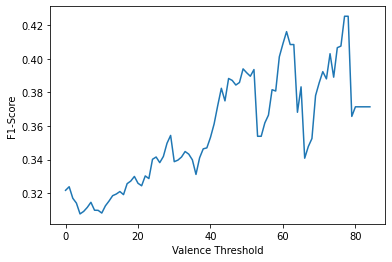

In [39]:
plt.plot(f1List[:85])
plt.xlabel("Valence Threshold")
plt.ylabel("F1-Score")
plt.show()

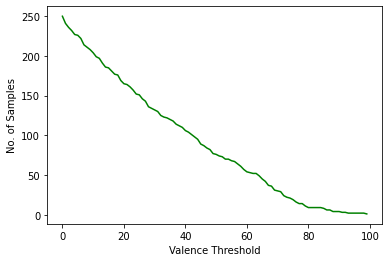

In [41]:
plt.plot(pdLen,"g")
plt.xlabel("Valence Threshold")
plt.ylabel("No. of Samples")
plt.show()

In [33]:
buffDf=valFilt(semdf,61)
semeval_pred=Report(buffDf,EmoVec,vectorizer,report=False)
np.mean(f1_score(buffDf.index,semeval_pred,average=None))

0.41622559865051534

In [34]:
accuracy_score(buffDf.index,semeval_pred)

0.5283018867924528

- Testing the VSM model with a complex statement! yet it classified it correctly!

In [46]:
print(f"\n\t>>> Emotion: {EmowavE('a perfectly parceled dead body')}")


	>>> Emotion: fear
